In [12]:
#importamos librerías
#basico

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split # nos va permitir dividir los datos
from sklearn.linear_model import LogisticRegression # Herramienta para hacer la regresión linea
from sklearn import metrics

In [13]:
#cargamos los datos
test_df = pd.read_csv('test_x.csv')
train_df = pd.read_csv('train.csv')
tweets_df = pd.read_csv('tweets_from2015_#Ibex35.csv')

### un vistazo al dataset

In [14]:
train_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1


In [15]:
test_df.head()

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0


In [16]:
tweets_df.head()

,tweetDate,handle,text
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,He hecho el repaso de todos los componentes de...
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,Els projectes que han presentat les empreses d...
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en ..."
3,Tue Apr 05 07:23:16 +0000 2022,zonavalue,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...
4,Thu Mar 31 16:07:43 +0000 2022,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0..."


### Data Cleaning

In [17]:
#informacion del tipo de dato del dataframe
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_index  726 non-null    int64  
 1   Date        726 non-null    object 
 2   Open        726 non-null    float64
 3   High        726 non-null    float64
 4   Low         726 non-null    float64
 5   Close       726 non-null    float64
 6   Adj Close   726 non-null    float64
 7   Volume      726 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.5+ KB


### Limpieza de los datos

In [18]:
#Para rellenar los valores nulos utilizaremos la interpolación (semanal)
#Akima para suavizar los cambios abrutos
train_df_interpolate = train_df.copy()
interpolate_train_df = train_df[['Open','High','Low','Close','Adj Close','Volume']].interpolate(method='akima',limit=3,axis=0)
train_df_interpolate[['Open','High','Low','Close','Adj Close','Volume']] = interpolate_train_df
train_df_interpolate['Date'] = pd.to_datetime(train_df_interpolate['Date'])

test_df_interpolate = test_df.copy()
interpolate_test_df = test_df[['Open','High','Low','Close','Adj Close','Volume']].interpolate(method='akima',limit=3,axis=0)
test_df_interpolate[['Open','High','Low','Close','Adj Close','Volume']] = interpolate_test_df
test_df_interpolate['Date'] = pd.to_datetime(test_df_interpolate['Date'])


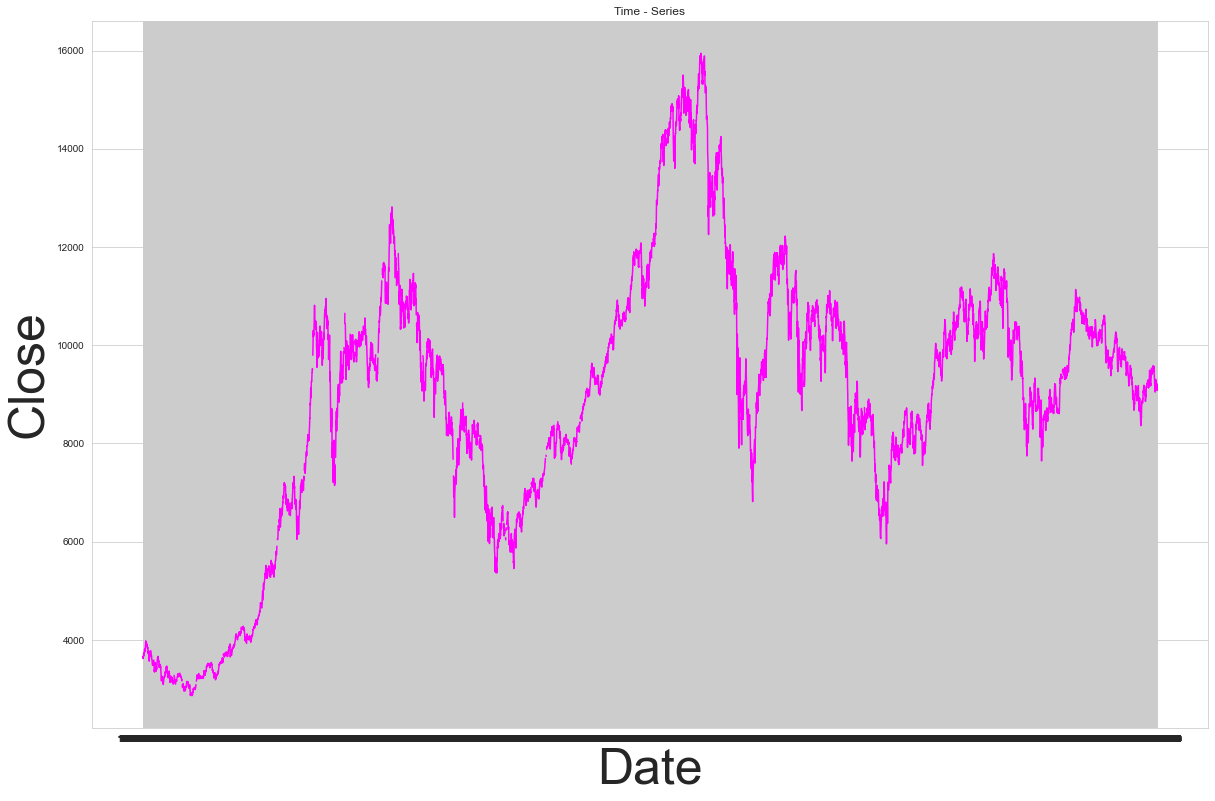

In [19]:
# plot
date = train_df['Date']
close = train_df['Close']
plt.figure(figsize=(20,13))
plt.xlabel('Date',fontsize=50)
plt.ylabel('Close',fontsize=50)

plt.title('Time - Series')
plt.plot(date,close,color='magenta')
plt.show()

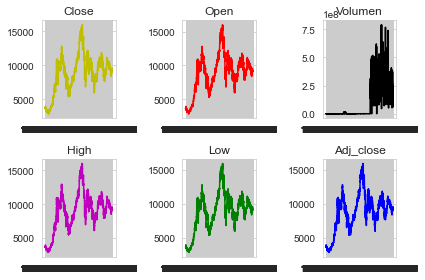

In [20]:
#date = train_df['Date']
#close = train_df['Close']
Open = train_df['Open']
High = train_df['High']
Low  = train_df['Close']
Adj_close  = train_df['Adj Close']
Volumen = train_df['Volume']
fig , axes = plt.subplots(2,3)
axes[0,0].plot(date,close,'y')
axes[0,0].set_title('Close')
axes[0,1].plot(date,Open,'r')
axes[0,1].set_title('Open')
axes[0,2].plot(date,Volumen,'black')
axes[0,2].set_title('Volumen')
axes[1,0].plot(date,High,'m')
axes[1,0].set_title('High')
axes[1,1].plot(date,Low,'g')
axes[1,1].set_title('Low')
axes[1,2].plot(date,Adj_close,'b')
axes[1,2].set_title('Adj_close')
fig.tight_layout()
plt.show()


Sospechoso la gráfica de los volúmenes, a qué aclararlo hallando la matriz de correlación

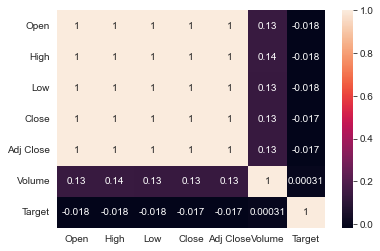

In [21]:
df_corr = train_df.corr()
sns.heatmap(df_corr,annot=True)
plt.show()
#Descartamos la columna Volumne por su baja correlación
#Y utilizaremos una columna ya que tienen una misma correlación

In [22]:
feature_cols = ['Open','High','Low','Close','Adj Close','Volume']
x = interpolate_train_df[feature_cols]
y = train_df['Target']

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2 ,random_state=0 )

In [24]:
model = LogisticRegression(max_iter=100)
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

In [56]:
y_pred_test = model.predict(test_df[feature_cols])
y_pred_test = pd.Series(y_pred_test,name='Target')
prediction = pd.concat([test_df['test_index'],y_pred_test],axis=1)
prediction

,test_index,Target
0,6557,1
1,6558,1
2,6559,1
3,6560,1
4,6561,1
...,...,...
721,7278,1
722,7279,1
723,7280,1
724,7281,1


In [57]:
prediction.to_csv('predictions.csv')

In [60]:
prediction.to_json('predictions.json')

In [59]:
score = metrics.accuracy_score(Y_test,y_pred)
print("Exactitud: ",score)

Exactitud:  0.5186880244088482
